In [1]:
import os 
os.environ["PATH"] += os.pathsep + '/home/zhangchen/latex/bin/x86_64-linux'
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [2]:
import os
import sys

script_path = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(script_path))

# Toy example

Test RFT and GFT simulation

In [3]:
import torch
import time
eta = 0.01  # Learning rate.
num_iterations = 5000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

In [4]:
# Create toy dataset.
def f_star(x):
    y = 1/np.sqrt(2*torch.pi*5**2)*torch.exp(-(x)** 2/(2*5**2))
    return y

In [5]:
# Create toy dataset.
def f_0(x):
    y = 0*x
    return y

In [6]:
# Obtain data.
pixels = torch.arange(-14, 14, 0.1)

In [7]:
# Create toy dataset.
def sp(x):
    y = 1/np.sqrt(2*torch.pi*8**2)*torch.exp(-(x)** 2/(2*8**2))
    #y = (1/np.sqrt(2*torch.pi*4**2)*torch.exp(-(x+6)** 2/(2*4**2)) + 2/np.sqrt(2*torch.pi*2**2)*torch.exp(-(x-5)** 2/(2*2**2)))/3
    return y
sp = sp(pixels)

In [8]:
# Create toy dataset.
def dp(x):
    y = 1/np.sqrt(2*torch.pi*8**2)*torch.exp(-(x+4)** 2/(2*8**2))
    #y = (1/np.sqrt(2*torch.pi*4**2)*torch.exp(-(x+6)** 2/(2*4**2)) + 2/np.sqrt(2*torch.pi*2**2)*torch.exp(-(x-5)** 2/(2*2**2)))/3
    return y
dp = dp(pixels)

In [9]:
# Create toy dataset.
def dp2(x):
    y = 1/np.sqrt(2*torch.pi*8**2)*torch.exp(-(x+7)** 2/(2*8**2))
    #y = (1/np.sqrt(2*torch.pi*4**2)*torch.exp(-(x+6)** 2/(2*4**2)) + 2/np.sqrt(2*torch.pi*2**2)*torch.exp(-(x-5)** 2/(2*2**2)))/3
    return y
dp2 = dp2(pixels)

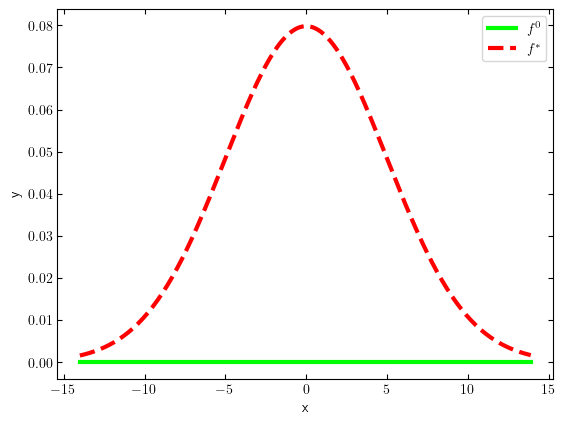

In [10]:
y = f_star(pixels)
y_0 = f_0(pixels)

plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
plt.plot(pixels,y,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    Adapted
    Tensorial
    x_1: [[1],[2]] two different subexample: example_1; example_2
    x_2: [[1,2,3,...],[1,2,3,...]] two different subpiexls: 
    return: [[kernel result 1],[kernel result 1]]
    '''
    return torch.exp(-(((x_1 - x_2) / 0.5) ** 2))

In [12]:
#, batch
def greedy_1(y_t, y_s):
    '''
    Adapted
    it can be threshold if batch <=1
    y_t: [[y_t_1],[y_t_1]], y_t_1: y values same length as pixels
    y_s: [[y_s_1],[y_s_1]]
    output: index of top k in x_list corresponded to y_t [[top_k list],[top_k list]]
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    return ind

Square loss $L[f]=(y_i-f(x_i))^2$  $DL[f]=-2(y_i-f(x_i))K(x_i, \cdot)$

In [13]:
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    batch gradient, not argmin
    If there are multiple minimal values then the indices of the first minimal value are returned.
    
    f_0: N(-10,1)
    obj: torch.arange(-14, 14, 0.5)
    input x: [1,2,3] int pixel
    input y: [label1,label2]
    input x_list: [1,2,3]
    input y_t: [x1,x2,x3] corresponds to x_list
    output gradient: [x1,x2,x3] long, same order as x_list
    K: 
    '''
    
    '''
    Search the index of input x
    '''
    _, ind = torch.topk(torch.abs(x_list-x),1, largest=False)
    f_x=y_t[ind]
    
    #square_loss
    '''
    unsqueeze for eache example mul each corresponded K
    '''
    gradient = -2*torch.unsqueeze((y-f_x), 1)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    '''
    gradient = torch.mean(gradient,axis=0)
    return gradient

In [14]:
#clear_print
'''
Only change points corresponding to example provided
'''
training_start_time = time.time()
#records
GFT = []
RFT = []
DFT = []
DDT = []
loss_GFT = []
loss_RFT = []
loss_DFT = []
loss_DDT = []
selexp_t = [] #only mark GFT
y_0 = f_0(pixels)
GFT.append(y_0)
RFT.append(y_0)
DFT.append(y_0)
DDT.append(y_0)
y_star = f_star(pixels)
loss_0 = np.linalg.norm(y_0-y_star)/len(y_star)
loss_GFT.append(loss_0)
loss_RFT.append(loss_0)
loss_DFT.append(loss_0)
loss_DDT.append(loss_0)
#selexp_t.append(float('nan')) no need to add nan, the first selected is based on f^0

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    #----------------------------GFT
    sel_idx = greedy_1(GFT[-1], y_star)
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    selexp_t.append(float(example))
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    GFT.append((GFT[-1] -eta*gradient(example, label, pixels, GFT[-1], rbf_kernel)))
    loss_GFT.append(np.linalg.norm(GFT[-1]-y_star)/len(y_star))
    
    #----------------------------RFT
    np.random.seed(iter_count)
    sel_idx = np.random.choice(range(len(y_star)),size=1,p=(sp/sp.sum()).numpy())
    
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    RFT.append((RFT[-1] -eta*gradient(example, label, pixels, RFT[-1], rbf_kernel)))
    loss_RFT.append(np.linalg.norm(RFT[-1]-y_star)/len(y_star))
    
    #----------------------------Different RFT
    np.random.seed(iter_count*2+1)
    sel_idx = np.random.choice(range(len(y_star)),size=1,p=(dp/dp.sum()).numpy())
    
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    DFT.append((DFT[-1] -eta*gradient(example, label, pixels, DFT[-1], rbf_kernel)))
    loss_DFT.append(np.linalg.norm(DFT[-1]-y_star)/len(y_star))
    
    #----------------------------more Different RFT
    np.random.seed(iter_count*3+2)
    sel_idx = np.random.choice(range(len(y_star)),size=1,p=(dp2/dp2.sum()).numpy())
    
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    label = f_star(example)
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    DDT.append((DDT[-1] -eta*gradient(example, label, pixels, DDT[-1], rbf_kernel)))
    loss_DDT.append(np.linalg.norm(DDT[-1]-y_star)/len(y_star))
    
    iter_count += 1


In [15]:
save_path = os.path.join(script_path,'out','toy')

In [16]:
torch.save([GFT, RFT, DFT, DDT, selexp_t, loss_GFT, loss_RFT, loss_DFT, loss_DDT],save_path+'/RFTmu_GFT.pt')

Load data

In [4]:
save_path = os.path.join(script_path,'out','toy')

In [15]:
GFT, RFT, DFT, DDT, selexp_t, loss_GFT, loss_RFT, loss_DFT, loss_DDT= torch.load(save_path+'/RFTmu_GFT.pt')

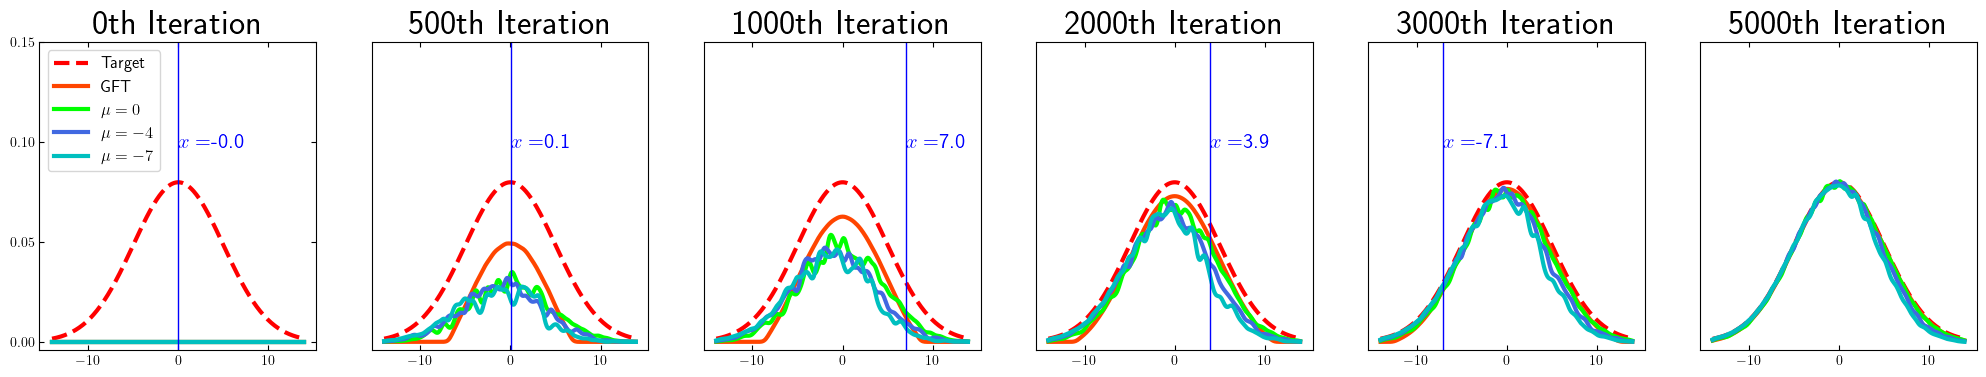

In [16]:
#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
ite_list = [0, 500, 1000, 2000, 3000, 5000]

sf = plt.figure(figsize=(25,4))

ind = 0

for i in ite_list:
    ind += 1
    
    plt.subplot(1,len(ite_list),ind)
    plt.plot(pixels,y,color='red',label='Target', linestyle='dashed', linewidth=3)
    plt.plot(pixels,GFT[i],color='orangered',label='GFT', linestyle='-', linewidth=3)
    plt.plot(pixels,RFT[i],color='lime',label=r'$\mu=0$', linestyle='-', linewidth=3)
    plt.plot(pixels,DFT[i],color='royalblue',label=r'$\mu=-4$' , linestyle='-', linewidth=3)
    plt.plot(pixels,DDT[i],color='c',label=r'$\mu=-7$', linestyle='-', linewidth=3)
    if ind < len(ite_list):
        plt.axvline(x=selexp_t[i],ls="-",c="b", linewidth=1)
        plt.text(selexp_t[i],0.1,r'$x=${:.1f}'.format(selexp_t[i]),fontdict={'size':'15','color':'b'},horizontalalignment='left',verticalalignment='center')
    plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
    plt.title('{}th Iteration'.format(i),size = 25)
    plt.yticks(np.arange(0, 0.2, .05))
    if ind==1: plt.legend(loc='upper left', prop={'size': 12})
    if ind >1: 
        plt.yticks([]) 
    
plt.show()

sf.savefig(save_path+'/RFTmu_GFT.pdf',bbox_inches='tight')

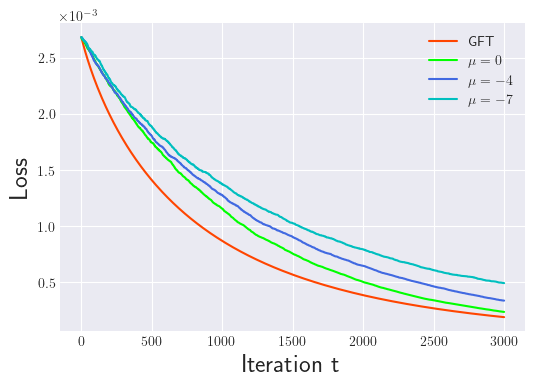

In [17]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
plt.plot(loss_GFT[0:3000],color='orangered',linestyle='-',label='GFT')
plt.plot(loss_RFT[0:3000],color='lime',linestyle='-',label=r'$\mu=0$')
plt.plot(loss_DFT[0:3000],color='royalblue',linestyle='-',label=r'$\mu=-4$')
plt.plot(loss_DDT[0:3000],color='c',linestyle='-',label=r'$\mu=-7$')

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.ticklabel_format(style='sci', scilimits=(-3,-2), axis='y',useMathText=True)
plt.legend()
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.show()

sf.savefig(save_path+'/Loss_RFTmu_GFT.pdf',bbox_inches='tight')

----------------------------

## Mixture Gaussian

### Vanilla

In [3]:
import torch
import time
eta = 0.01  # Learning rate.
num_iterations = 5000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

$ y_i = \frac{1}{3\sqrt(2\pi)}e^{-\frac{\left(x_i + 2\right)^2}{2}} + \frac{2}{3\sqrt(2\pi)}e^{-\frac{\left(x_i - 2\right)^2}{2}}$

In [4]:
'''# Create toy dataset.
def f_star_raw(x):
    y = (2/(2*np.sqrt(2*torch.pi))*torch.exp(-((x+2)/2)** 2/2) + 1/np.sqrt(2*torch.pi)*torch.exp(-(x-2)** 2/2))/3
    return y'''

'# Create toy dataset.\ndef f_star_raw(x):\n    y = (2/(2*np.sqrt(2*torch.pi))*torch.exp(-((x+2)/2)** 2/2) + 1/np.sqrt(2*torch.pi)*torch.exp(-(x-2)** 2/2))/3\n    return y'

In [5]:
# Create toy dataset. -2，2
def f_star_1(x):
    w_1 = 1/3
    mu_1 = -2
    sigma_1 = 1.5
    
    w_2 = 1-w_1
    mu_2 = 2
    sigma_2 = 1
    y = w_1/(sigma_1*np.sqrt(2*torch.pi))*torch.exp(-((x-mu_1)/sigma_1)** 2/2)+w_2/(
        sigma_2*np.sqrt(2*torch.pi))*torch.exp(-((x-mu_2)/sigma_2)** 2/2)
    return y

In [6]:
# Create toy dataset. 2，1
def f_star_2(x):
    w_1 = 3/4
    mu_1 = -2
    sigma_1 = 1.5
    
    w_2 = 1-w_1
    mu_2 = 2
    sigma_2 = 1
    y = w_1/(sigma_1*np.sqrt(2*torch.pi))*torch.exp(-((x-mu_1)/sigma_1)** 2/2)+w_2/(
        sigma_2*np.sqrt(2*torch.pi))*torch.exp(-((x-mu_2)/sigma_2)** 2/2)
    return y

In [7]:
# Create toy dataset. -2，2
def f_0_1(x):
    mu = -2
    sigma = 1.5
    y = 1/(sigma*np.sqrt(2*torch.pi))*torch.exp(-((x-mu)/sigma)** 2/2)
    return y

In [8]:
# Create toy dataset. 2，1
def f_0_2(x):
    mu = 2
    sigma = 1
    y = 1/(sigma*np.sqrt(2*torch.pi))*torch.exp(-((x-mu)/sigma)** 2/2)
    return y

In [9]:
# Obtain data.
#pixels_raw = torch.arange(-14, 14, 0.1)
pixels_1 = torch.arange(-7, 7, 0.1)
pixels_2 = torch.arange(-7, 7, 0.1)
pixels = torch.vstack([pixels_1,pixels_2])

In [10]:
CmbPlot_pixels_1 = torch.arange(-7, 7, 0.1) 
CmbPlot_pixels_2 = torch.arange(-7, 7, 0.1)
CmbPlot_y_star_1 = f_star_1(CmbPlot_pixels_1)
CmbPlot_y_star_2 = f_star_2(CmbPlot_pixels_2)
mCmbPlot_pixels_1, mCmbPlot_pixels_2 = torch.meshgrid(CmbPlot_pixels_1, CmbPlot_pixels_2)

/home/zhangchen/anaconda3/envs/mytorch/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


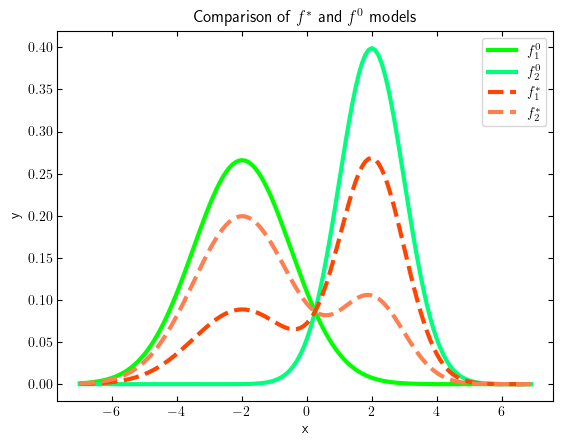

In [11]:
#y_raw = f_star_raw(pixels_raw)
y_0_1 = f_0_1(pixels_1)
y_0_2 = f_0_2(pixels_2)
y_star_1 = f_star_1(pixels_1)
y_star_2 = f_star_2(pixels_2)

#plt.plot(pixels_raw,y_raw,color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
plt.plot(pixels_1,y_0_1,color='lime',label=r'$f^0_1$', linewidth=3)
plt.plot(pixels_2,y_0_2,color='springgreen',label=r'$f^0_2$', linewidth=3)
plt.plot(pixels_1,y_star_1,color='orangered',label=r'$f_1^*$', linestyle='--', linewidth=3)
plt.plot(pixels_2,y_star_2,color='coral',label=r'$f_2^*$', linestyle='--', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.title('Comparison of '+r'$f^*$'+' and '+r'$f^0$'+' models')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Training

In [16]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    Adapted
    Tensorial
    x_1: [[1],[2]] two different subexample: example_1; example_2
    x_2: [[1,2,3,...],[1,2,3,...]] two different subpiexls: 
    return: [[kernel result 1],[kernel result 1]]
    '''
    return torch.exp(-(((x_1 - x_2) / 0.5) ** 2))

In [17]:
#, batch
def greedy_1(y_t, y_s):
    '''
    Adapted
    it can be threshold if batch <=1
    y_t: [[y_t_1],[y_t_1]], y_t_1: y values same length as pixels
    y_s: [[y_s_1],[y_s_1]]
    output: index of top k in x_list corresponded to y_t [[top_k list],[top_k list]]
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1,dim=1)
    return ind

Square loss $L[f]=(y_i-f(x_i))^2$  $DL[f]=-2(y_i-f(x_i))K(x_i, \cdot)$

In [18]:
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    1 input for each sub problem
    If there are multiple minimal values then the indices of the first minimal value are returned.
    
    obj: torch.arange(-14, 14, 0.5)
    input x: [[1],[2]] int pixel index
    input y: [[label],[label]]
    input x_list: [[1,2,3,...],[1,2,3,...]]
    input y_t: [[x1,x2,x3,...],[x1,x2,x3,...]] corresponds to x_list
    output gradient: [[x1,x2,x3],[x1,x2,x3]] long, same order as x_list
    K: 
    '''
    
    '''
    Search the index of input x
    '''
    _, ind = torch.topk(torch.abs(x_list-x),1, largest=False)
    f_x=torch.vstack([y_t[0,ind[0]],y_t[1,ind[1]]])#y_t[0,ind]#same long as x  ADD 0, to adapt Tensorial return f_x is a x-like tensor.
    
    #square_loss
    '''
    unsqueeze for eache example mul each corresponded K
    '''
    '''print('y: ', y)
    print('f_x: ', f_x)
    print('y-f_x: ', y-f_x)
    print('K: ', K(x, x_list))'''
    gradient = -2*(y-f_x)*K(x, x_list)
    #print(gradient[0]-gradient[1])# shape is right
    return gradient

In [ ]:
#clear_print
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
selexp_t = []

y_0_1 = f_0_1(pixels_1)
y_0_2 = f_0_2(pixels_2)
y_0 = torch.vstack([y_0_1,y_0_2])
f_t.append(y_0)

y_star_1 = f_star_1(pixels_1)
y_star_2 = f_star_2(pixels_2)
y_star = torch.vstack([y_star_1,y_star_2])

rcvy_0 = torch.matmul(y_0[0,:].reshape(len(y_0[0,:]),1), y_0[1,:].reshape(1,len(y_0[1,:])))
rcvy_star = torch.matmul(y_star[0,:].reshape(len(y_star[0,:]),1), y_star[1,:].reshape(1,len(y_star[1,:])))
loss_0 = torch.norm(rcvy_0-rcvy_star)/(len(y_star[0,:])*len(y_star[1,:]))
loss_t.append(loss_0)

tm_t.append(0)
#selexp_t.append(float('nan')) no need to add nan, the first selected is based on f^0

iter_count = 0
step = 0.05*num_iterations
while iter_count < num_iterations:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_1(f_t[-1], y_star)
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = torch.vstack([pixels[0,sel_idx[0]],pixels[1,sel_idx[1]]])# ADD 0, to adapt Tensorial return f_x is a x-like tensor.
    label = torch.vstack([y_star[0,sel_idx[0]],y_star[1,sel_idx[1]]])
    #label = torch.tensor([[f_star_1(example[0])],[f_star_2(example[1])]])
    
    selexp_t.append(example.numpy())
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    
    rcvf_t = torch.matmul(f_t[-1][0,:].reshape(len(f_t[-1][0,:]),1), f_t[-1][1,:].reshape(1,len(f_t[-1][1,:])))
    loss = torch.norm(rcvf_t-rcvy_star)/(len(y_star[0,:])*len(y_star[1,:]))
    loss_t.append(loss)
    
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

In [19]:
Vanillaloss_t=loss_t

In [23]:
save_path = os.path.join(script_path,'out','toy')

In [9]:
torch.save([f_t, Vanillaloss_t, tm_t, selexp_t, pixels, y_star],save_path+'/Vanilla.pt')

Load data

In [9]:
save_path = os.path.join(script_path,'out','toy')

In [10]:
f_t, Vanillaloss_t, tm_t, selexp_t, pixels, y_star= torch.load(save_path+'/Vanilla.pt')

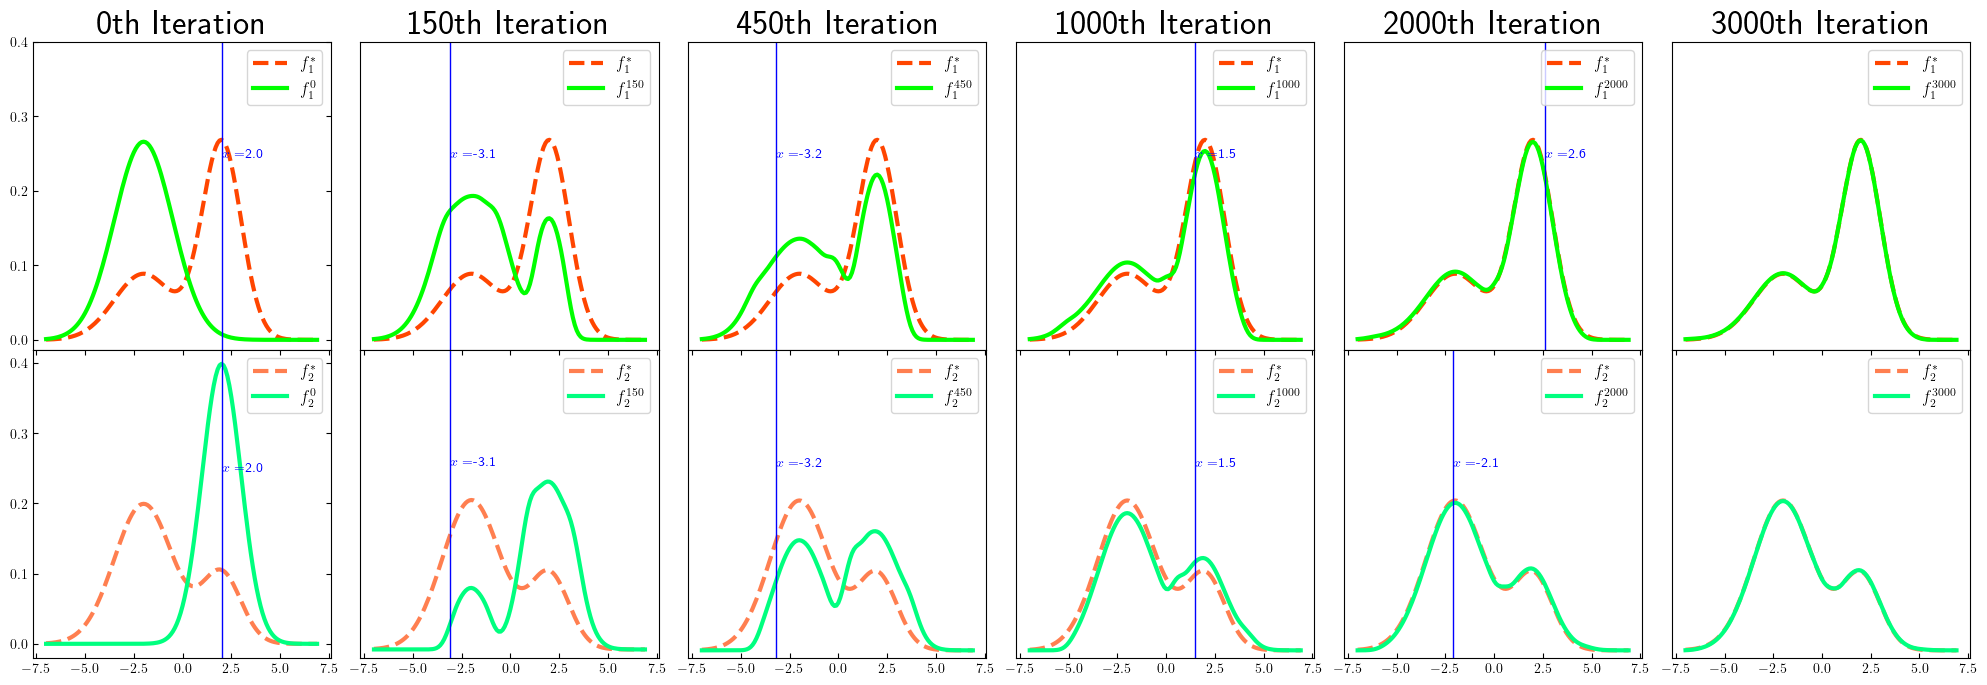

In [11]:
#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
ite_list = [0, 150, 450, 1000, 2000, 3000]
color = np.array([['lime','orangered'],['springgreen','coral']])
fig = plt.figure(figsize=(25,8))

ind = 0

grid = plt.GridSpec(2, len(ite_list), wspace = .1, hspace = 0)

for prl in range(2):
    for i in ite_list:
        j = ite_list.index(i)
        exec(f"ax=fig.add_subplot(grid{[prl*len(ite_list)+j]})")
        ind += 1
        #plt.subplot(prl+1,len(ite_list),ind)
        plt.plot(pixels[prl],y_star[prl],color='{}'.format(color[prl,1]),label=r'$f^*_{{{}}}$'.format(prl+1), linestyle='dashed', linewidth=3)
        plt.plot(pixels[prl],f_t[i][prl],color='{}'.format(color[prl,0]),label=r'$f^{{{}}}_{{{}}}$'.format(i,prl+1), linestyle='-', linewidth=3)
        if ind%len(ite_list) != 0 and ind != 0:
            plt.axvline(x=selexp_t[i][prl],ls="-",c="b", linewidth=1)
            plt.text(selexp_t[i][prl],0.25,r'$x=${:.1f}'.format(float(selexp_t[i][prl])),fontdict={'size':'10','color':'b'},horizontalalignment='left',verticalalignment='center')
        plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
        plt.legend(loc='upper right', prop={'size': 12})
        if prl == 0:
            plt.title('{}th Iteration'.format(i),size = 25)
            plt.xticks([]) 
        plt.yticks(np.arange(0, 0.401, .1))
        if ind%len(ite_list) != 1: 
            plt.yticks([]) 
plt.show()

fig.savefig(save_path+'/Vanilla.pdf',bbox_inches='tight')

### Communicated

In [12]:
import torch
import time
eta = 0.001  # Learning rate.
num_iterations = 5000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

Train Advanced matrix A

In [13]:
y_0_1 = f_0_1(pixels_1)
y_0_2 = f_0_2(pixels_2)
y_0 = torch.vstack([y_0_1,y_0_2])

y_star_1 = f_star_1(pixels_1)
y_star_2 = f_star_2(pixels_2)
y_star = torch.vstack([y_star_1,y_star_2])

In [28]:
f_0_T = y_0.T
f_s_T = y_star.T

In [29]:
class AdvancedM(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedM, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        torch.nn.init.zeros_(self.linear.weight)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [30]:
MatrixA = AdvancedM(len(f_t[0]), len(f_t[-1]))
optimizer = torch.optim.SGD(MatrixA.parameters(), lr=eta)

In [ ]:
#clear_print
loss_t = []

loss_t.append(torch.norm(MatrixA(f_0_T)-f_s_T))

iter_count = 0
while iter_count < num_iterations:
    iter_count += 1
    
    loss = torch.norm(MatrixA(f_0_T)-f_s_T)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if loss.item() > loss_t[-1]:
        break    
    loss_t.append(loss.item())
    print(iter_count,'-th test loss:', loss_t[-1])

In [32]:
A = MatrixA.state_dict()['linear.weight']
A

tensor([[0.3333, 0.6668],
        [0.7499, 0.2501]])

In [33]:
f_t = []
loss_t = []

f_t.append(y_0.cpu())
f_t.append(MatrixA(f_0_T).detach().T.cpu())

rcvy_0 = torch.matmul(y_0[0,:].reshape(len(y_0[0,:]),1), y_0[1,:].reshape(1,len(y_0[1,:])))
rcvy_star = torch.matmul(y_star[0,:].reshape(len(y_star[0,:]),1), y_star[1,:].reshape(1,len(y_star[1,:])))
loss_0 = torch.norm(rcvy_0-rcvy_star)/(len(y_star[0,:])*len(y_star[1,:]))
loss_t.append(loss_0)

f_1 = MatrixA(f_0_T).detach().T
rcvf_1 = torch.matmul(f_1[0,:].reshape(len(f_1[0,:]),1), f_1[1,:].reshape(1,len(f_1[1,:])))
loss_1 = torch.norm(rcvf_1-rcvy_star)/(len(y_star[0,:])*len(y_star[1,:]))

loss_t.append(loss_1)

In [36]:
Advancedloss_t = torch.zeros_like(torch.tensor(Vanillaloss_t))
Advancedloss_t[0] = loss_t[0]
Advancedloss_t[1:-1] = loss_t[1]

In [40]:
save_path = os.path.join(script_path,'out','toy')

In [41]:
torch.save([f_t, Advancedloss_t, pixels, A],save_path+'/Advanced.pt')

Load data

In [4]:
save_path = os.path.join(script_path,'out','toy')

In [5]:
f_t, Advancedloss_t, pixels, A = torch.load(save_path+'/Advanced.pt')

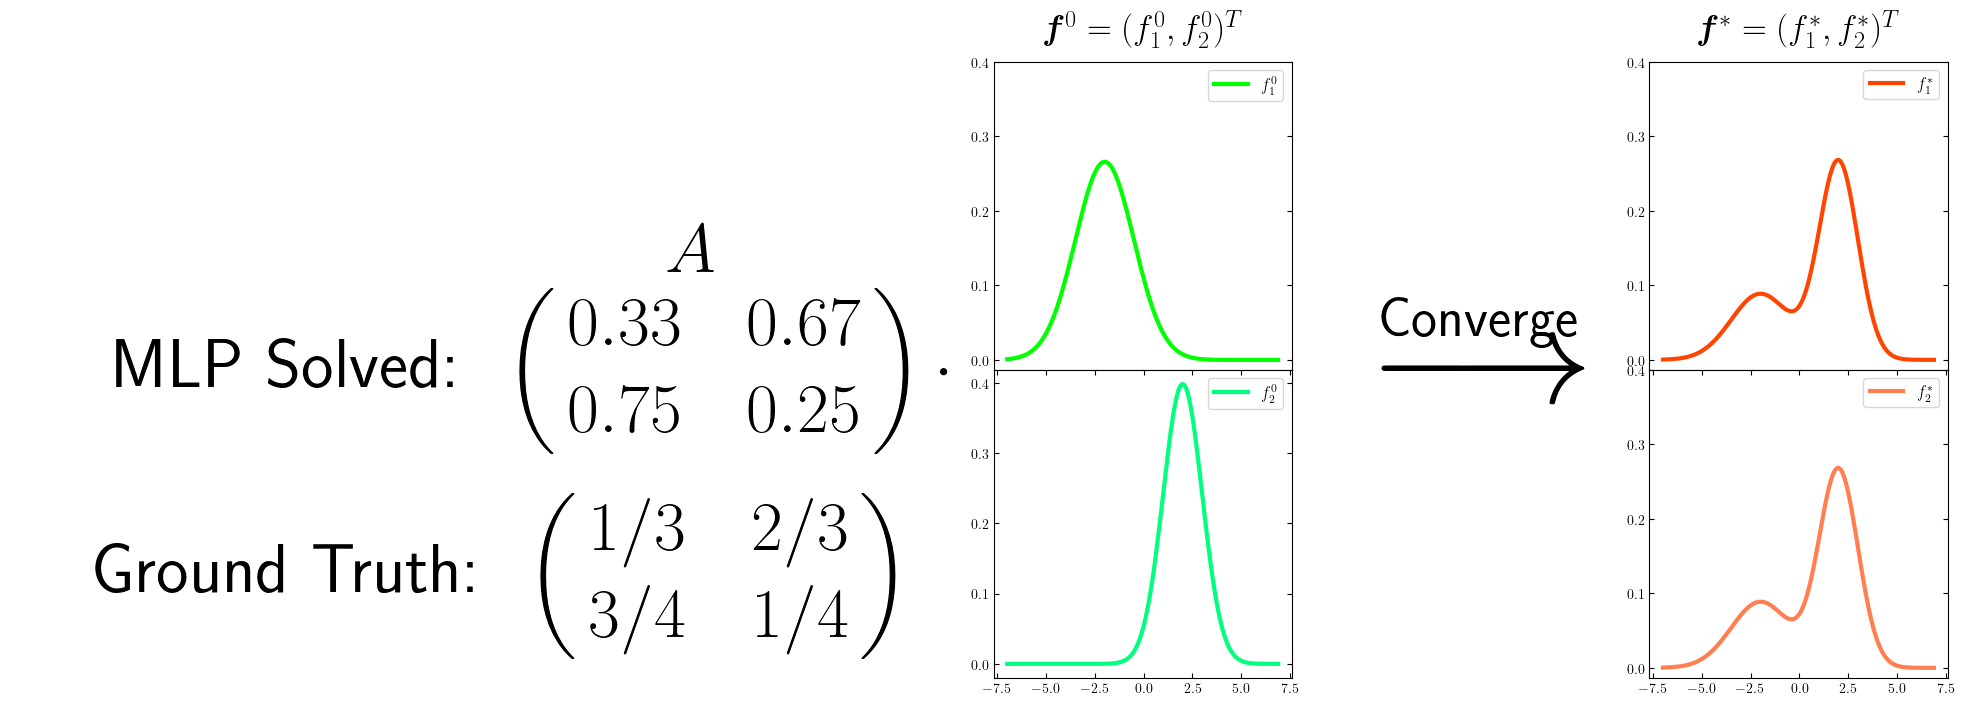

In [6]:
#plt.plot(pixels,y_0,color='lime',label=r'$f^0$', linewidth=3)
fig = plt.figure(figsize=(25,8))
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')
#matplotlib.verbose.level = 'debug-annoying'
grid = plt.GridSpec(2, 6, wspace = .1, hspace = 0)
#----------------------------------------------Matrix operation--------------------------------------------------------
ax=fig.add_subplot(grid[:,0:3])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
#plt.plot(pixels_2,y_0_2,color='springgreen',label=r'$f^0_2$', linewidth=3)

plt.text(2,5.5,'MLP Solved: ',
         fontdict={'size':'50','color':'black'},horizontalalignment='left',verticalalignment='center')
plt.text(5.8,5.5,r'$\left(\matrix{{{}}}\right)\cdot$'.format('{:.2f} & {:.2f} \cr {:.2f} & {:.2f}'.
                                                             format(A[0,0],A[0,1],A[1,0],A[1,1]) ),
         fontdict={'size':'50','color':'black'},horizontalalignment='left',verticalalignment='center')

plt.text(1.8,2.5,'Ground Truth: ',
         fontdict={'size':'50','color':'black'},horizontalalignment='left',verticalalignment='center')
plt.text(6,2.5,r'$\left(\matrix{ 1/3 & 2/3 \cr 3/4 & 1/4 }\right)$',
         fontdict={'size':'50','color':'black'},horizontalalignment='left',verticalalignment='center')

plt.text(7.2,7.2,r'$A$',
         fontdict={'size':'50','color':'black'},horizontalalignment='left',verticalalignment='center')
ax.set_axis_off()


#------------------------------------------------f^0------------------------------------------------------
#ax=fig.add_subplot(2,4,1)
exec(f"ax=fig.add_subplot(grid{[3]})")
plt.plot(pixels[0],f_t[0][0],color='lime',label=r'$f^0_1$', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='upper right', prop={'size': 12})
plt.yticks(np.arange(0, 0.401, .1))
plt.title(r'$\bm{f}^0=(f^0_1,f^0_2)^T$',y=1.05,size = 25)
plt.xticks([]) 

#ax=fig.add_subplot(2,4,5)
exec(f"ax=fig.add_subplot(grid{[9]})")
plt.plot(pixels[1],f_t[0][1],color='springgreen',label=r'$f^0_2$', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='upper right', prop={'size': 12})
plt.yticks(np.arange(0, 0.401, .1))

#-----------------------------------------------Arrow-------------------------------------------------------
ax=fig.add_subplot(grid[:,4])
ax.set_ylim(1, 10)
ax.set_xlim(1, 10)
#plt.plot(pixels_2,y_0_2,color='springgreen',label=r'$f^0_2$', linewidth=3)

plt.text(2.8,6.2,'Converge',
         fontdict={'size':'40','color':'black'},horizontalalignment='left',verticalalignment='center')
plt.text(2.8,5.5,r'$\longrightarrow$',
         fontdict={'size':'100','color':'black'},horizontalalignment='left',verticalalignment='center')
ax.set_axis_off()



#---------------------------------------------f^*---------------------------------------------------------
#ax=fig.add_subplot(2,4,4)
exec(f"ax=fig.add_subplot(grid{[5]})")
plt.plot(pixels[0],f_t[1][0],color='orangered',label=r'$f_1^*$', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='upper right', prop={'size': 12})
plt.yticks(np.arange(0, 0.401, .1))
plt.title(r'$\bm{f}^*=(f^*_1,f^*_2)^T$',y=1.05 ,size = 25)
plt.xticks([]) 

#ax=fig.add_subplot(2,4,8)
exec(f"ax=fig.add_subplot(grid{[11]})")
plt.plot(pixels[1],f_t[1][0],color='coral',label=r'$ f_2^*$', linewidth=3)
plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='upper right', prop={'size': 12})
plt.yticks(np.arange(0, 0.401, .1))

plt.show()
fig.savefig(save_path+'/Advanced.pdf',bbox_inches='tight')

### Single; Bivariate Normal

In [11]:
import torch
import time
eta = 0.01  # Learning rate.
num_iterations = 10000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

In [8]:
# Obtain pixels.
'''torch.arange(-14, 3, 0.5)
x2 = torch.arange(3, 14, 0.5)'''
x1 = torch.arange(-7, 7, 0.1)
x2 = torch.arange(-7, 7, 0.1)
x1, x2 = torch.meshgrid(x1, x2)
pixels = torch.vstack((x1.flatten(),x2.flatten())).T.cuda()

D:\Anaconda\envs\mytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:
print('GPU: ',torch.cuda.is_available())
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU:  True


In [14]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [15]:
# The kernel we use.
def rbf_kernel(x_1, x_2):
    '''
    x_1: [[13,15],[12,17]]
    x_2: [[10,16],[14,14],[11,13]]
    output: #row - #example
            #col - #list
        [[4.2484e-18, 3.3546e-04, 1.2664e-14],
        [2.0612e-09, 2.6103e-23, 2.9375e-30]]
    interleave: a,b,c -> a,a,b,b,c,c for cross norm
    reshape: split it to do block minus '-'
    '''
    big_x1 = torch.repeat_interleave(x_1,len(x_2),dim=0).reshape(len(x_1),len(x_2),2).cuda()
    norm = torch.norm ((big_x1 - x_2).type(dtype), dim=2)
    return torch.exp(-(((norm) / 0.5) ** 2)).cuda()

Multiplication way

In [16]:
def fun_opt(x, y):
    f = f_star_1(x)*f_star_2(y)
    '''rho = 13/(5*np.sqrt(10))
    mu_x = 2/3
    sig_x = 5/6
    
    mu_y = -2/3
    sig_y = np.sqrt(10)/3
    f = 1/( 2*np.pi*sig_x*sig_y*np.sqrt(1-rho**2) )*np.exp(  -1/(2*(1-rho**2)) * ( 
        ((x-mu_x)/sig_x)**2 - 2*rho*((x-mu_x)/sig_x)*((y-mu_y)/sig_y) + ((y-mu_y)/sig_y)**2 )  )'''
    return f

In [17]:
CmbPlot_zs = fun_opt(mCmbPlot_pixels_1.flatten(), mCmbPlot_pixels_2.flatten())
CmbPlot_Z_opt = CmbPlot_zs.reshape(len(CmbPlot_pixels_1),len(CmbPlot_pixels_2))#32*32

In [18]:
def fun_0(x, y):
    f = f_0_1(x)*f_0_2(y)
    '''rho = 13/(5*np.sqrt(10))
    mu_x = 2/3
    sig_x = 5/6
    
    mu_y = -2/3
    sig_y = np.sqrt(10)/3
    f = 1/( 2*np.pi*sig_x*sig_y*np.sqrt(1-rho**2) )*np.exp(  -1/(2*(1-rho**2)) * ( 
        ((x-mu_x)/sig_x)**2 - 2*rho*((x-mu_x)/sig_x)*((y-mu_y)/sig_y) + ((y-mu_y)/sig_y)**2 )  )'''
    return f

In [19]:
'''x1 = torch.arange(-14, 3, 0.5)
x2 = torch.arange(-3, 14, 0.5)
x1, x2 = torch.meshgrid(x1, x2)'''
zs = fun_opt(x1.flatten(), x2.flatten())
Z_opt = zs.reshape(x1.shape)#32*32

zs = fun_0(x1.flatten(), x2.flatten())
Z_0 = zs.reshape(x1.shape)

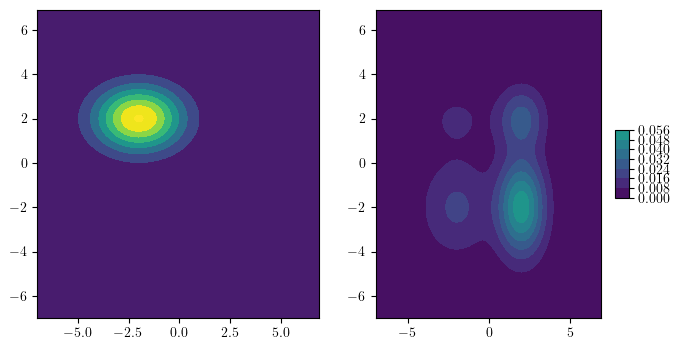

In [20]:
import matplotlib.pyplot as plt
import random
import matplotlib as mpl
import matplotlib

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.1)

fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121)
surf = ax.contourf(x1, x2,Z_0, norm = norm)

ax = fig.add_subplot(122)
surf = ax.contourf(x1, x2,Z_opt, norm = norm)
fig.colorbar(surf, shrink=0.22, aspect=5)

plt.show()

#### Training

In [21]:
def f_0(example):
    '''
    function format different from previous figure format.
    
    example: [[x,y],[x,y]]
    output: [z1,z2]
    '''
    
    Z = fun_0(example[:,0].cpu(), example[:,1].cpu())
    
    '''obj = torch.tensor(np.squeeze(Z_0, axis=None),dtype=torch.float64, device=None)
    
    #one point or many point
    if len(example.shape) > 1:
        x, y = example[:,0], example[:,1]
    else:
        x, y = example[0], example[1]

    Z = obj[x,y] # here we need to change the type to ap.array'''
    return Z.cuda()

In [22]:
def f_star(example):
    '''
    function format different from previous figure format.
    
    example: [[x,y],[x,y]]
    output: [z1,z2]
    '''
    
    Z = fun_opt(example[:,0].cpu(), example[:,1].cpu())
    
    '''obj = torch.tensor(np.squeeze(Z_0, axis=None),dtype=torch.float64, device=None)
    
    #one point or many point
    if len(example.shape) > 1:
        x, y = example[:,0], example[:,1]
    else:
        x, y = example[0], example[1]

    Z = obj[x,y] # here we need to change the type to ap.array'''
    return Z.cuda()

In [23]:
def greedy_1(y_t, y_s):
    '''
    it can be threshold if batch <=1
    y_t, y_s are [x1,x2,x3]
    output: index of top k in x_list corresponded to y_t
    '''
    dif = torch.abs(y_t-y_s)
    
    _, ind = torch.topk(dif,1)
    
    return ind

Previes example is int index, e.g., [0,10] that can be used directly, but now examples are stored float values that cannot be used directly

In [24]:
def gradient(x, y, x_list, y_t, K): #add a argument "type" for specified loss
    '''
    batch gradient, not argmin
    If there are multiple minimal values then the indices of the first minimal value are returned.
    
    f_0: '8'
    obj: 28*28
    input x: [[x1,x2],[x1,x2]] int pixel point
    input y: [label1,label2]
    input x_list: [[x1,x2],[x1,x2],[x1,x2]]
    input y_t: [x1,x2,x3] corresponds to x_list
    output gradient: [x1,x2,x3] long, same order as x_list
    K: K(2*2,dim=3*2) output 2*3 2:two input centor, 3:three compute list(pixel)
    '''
    if len(x.shape) == 1:
        x = torch.unsqueeze(x, 0)
    # according to the rule of pixel layout and assume figure are square
    wid = np.sqrt(len(x_list))
    w = torch.tensor([wid,1], dtype=torch.float64).cuda()
    #print(w.dtype,x.dtype)
    
    x_ind = x.detach().clone()
    # the first dimension is continuous so the intervel should be np.sqrt(len(x_list)) Then we use second dimension
    step = (x_list[1,1]-x_list[0,1])
    x_ind[:,0] = (x[:,0]-torch.min(x_list[:,0]))/step #0.5
    #np.sqrt, step should be the same
    x_ind[:,1] = (x[:,1]-torch.min(x_list[:,1]))/step #0.5
    
    ind = torch.matmul(x_ind.type(torch.float64).cuda(),w) #+1  no need to add 1 since the first one is indexed at 0
    ind = ind.type(torch.int64)
    f_x=y_t[ind]#same long as x
    #square_loss
    #print(torch.unsqueeze((y-f_x), 1))
    '''
    unsqueeze for eache example mul each corresponded K
    '''
    gradient = -2*torch.unsqueeze((y-f_x), 1)*K(x, x_list)
    
    '''
    mean->1*len(x_list)
    '''
    gradient = torch.mean(gradient,axis=0)
    print('gradient: ',torch.norm(gradient))
    return gradient.cuda()

#### Run

In [ ]:
#clear_print
training_start_time = time.time()
#records
f_t = []
loss_t = []
tm_t = []
y_0 = f_0(pixels)
f_t.append(y_0)
y_star = f_star(pixels)
loss_0 = torch.norm(y_0-y_star)/len(y_star)
loss_t.append(loss_0.cpu())
tm_t.append(0)

iter_count = 0
step = 0.05*num_iterations
while iter_count < 10000:
    '''
    if np.remainder(iter_count, step) == 0:
        sel_idx = greedy_B(f_t[-1], y_star, 1)
    
    for random selection, generate sel_idx by random, random seed can be set as iter_count
    '''
    
    sel_idx = greedy_1(f_t[-1], y_star)#, pool=True, plScale= 0.8
    '''
    np.random.seed(iter_count)
    sel_idx = np.random.randint(0,len(y_star),int(0.05*len(y_star)))
    '''
    
    '''
    example: [[x1,x2],[x1,x2]] int pixel point
    '''
    example = pixels[sel_idx]#torch.tensor([14,14])
    print(example)
    '''
    intorduce replacement
    '''
    label = f_star(example)
    
    '''
    torch.Size([784]) - torch.Size([784])
    '''
    f_t.append((f_t[-1] -eta*gradient(example, label, pixels, f_t[-1], rbf_kernel)))
    loss_t.append((torch.norm(f_t[-1]-y_star)/len(y_star)).cpu())
    tm_t.append(time.time() - training_start_time)
    iter_count += 1
    print(iter_count,'-th loss: ',loss_t[-1])
    print('Training finished, took {:.2f}s'.format(tm_t[-1]))

In [41]:
Singleloss_t=loss_t

In [42]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

In [9]:
torch.save([f_t, Singleloss_t, tm_t, x1, x2, pixels, Z_opt],save_path+'/Single.pt')

Load data

In [4]:
save_path = os.path.join(script_path,'out','toy')

In [5]:
f_t, Singleloss_t, tm_t, x1, x2, pixels, Z_opt = torch.load(save_path+'/Single.pt', map_location=torch.device('cpu'))

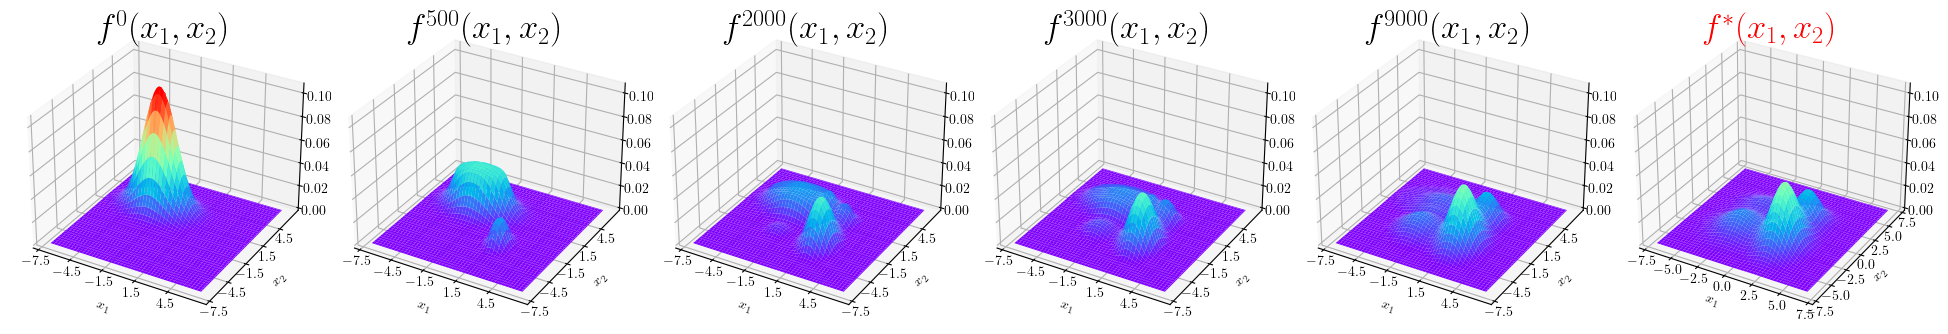

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib

norm = matplotlib.colors.Normalize(vmin=0, vmax=0.1)
z_min, z_max = 0, torch.max(f_t[0]) #torch.max(f_t[0].cpu())
#from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(25,4))

# Make data. Draw 0
'''X = np.arange(0, min_side, 1)
Y = np.arange(0, min_side, 1)
'''

ite_list = [0,500, 2000,3000, 9000] #[0,50,150,250,350, 550]


for i in ite_list:
    j = ite_list.index(i)
    ax = fig.add_subplot(1, len(ite_list)+1, j+1,projection='3d')#,projection='3d'
    
    #surf = ax.contourf(x1, x2, Z, norm = norm)
    ax.plot_surface(x1, x2, 
                    f_t[i].reshape(int(np.sqrt(len(pixels))),int(np.sqrt(len(pixels)))), 
                    norm = norm, cmap = 'rainbow')#f_t[i].cpu().reshape(int(np.sqrt(len(pixels))),int(np.sqrt(len(pixels)))), 
    ax.set_zlim([z_min, z_max])
    plt.xlabel(r'$x_1$', labelpad=-5)
    plt.ylabel(r'$x_2$', labelpad=-5)
    plt.xticks(torch.arange(-7.5, 7.5, 1)[::3])
    plt.yticks(torch.arange(-7.5, 7.5, 1)[::3])
    ax.tick_params(axis='x', which='major', pad=-5)
    ax.tick_params(axis='y', which='major', pad=-5)
    ax.tick_params(axis='z', which='major', pad=-1)

    '''if j > 0:
        plt.yticks([])'''
    

    #ax.view_init(20,-60)
    
    plt.title(r'$f^{{{}}}(x_1,x_2)$'.format(i),y=0.98,size = 25)

ax = fig.add_subplot(1, len(ite_list)+1, len(ite_list)+1,projection='3d')#,projection='3d'
#surf = ax.contourf(x1, x2,Z_opt, norm = norm)
ax.plot_surface(x1, x2, Z_opt, norm = norm, cmap = 'rainbow')
ax.set_zlim([z_min, z_max])
plt.xlabel(r'$x_1$', labelpad=-8)
plt.ylabel(r'$x_2$', labelpad=-8)
ax.tick_params(axis='x', which='major', pad=-5)
ax.tick_params(axis='y', which='major', pad=-5)
ax.tick_params(axis='z', which='major', pad=-1)
#plt.yticks([])
plt.title(r'$f^*(x_1,x_2)$',y=0.98,color='r',size = 25)
tight_coe = -0.03
fig.subplots_adjust(wspace=tight_coe, hspace=tight_coe)
plt.show()
fig.savefig(save_path+'/Single.pdf',bbox_inches='tight', pad_inches = 0.02)

## Combination of MINT and single

In [41]:
#data_path = os.path.join(script_path,'data','matching','cheetah.jpg')
save_path = os.path.join(script_path,'out','toy')

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

from matplotlib.text import Annotation

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)
        
def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

import numpy as np
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 
    
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)

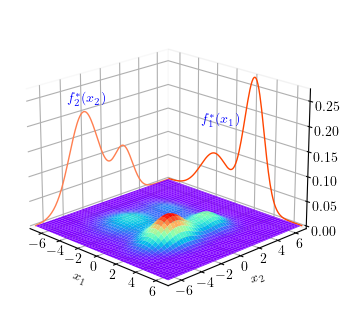

In [43]:
import matplotlib.pyplot as plt
import random
import matplotlib as mpl
import matplotlib

x_min, x_max = torch.min(CmbPlot_pixels_1), torch.max(CmbPlot_pixels_1)
y_min, y_max = torch.min(CmbPlot_pixels_2), torch.max(CmbPlot_pixels_2)
z_min, z_max = 0, torch.max(CmbPlot_y_star_1)

#norm = matplotlib.colors.Normalize(vmin=0, vmax=0.1)

fig = plt.figure(figsize=(4,4))


ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mCmbPlot_pixels_1, mCmbPlot_pixels_2, CmbPlot_Z_opt, cmap = 'rainbow')
ax.plot(CmbPlot_pixels_1.numpy(),CmbPlot_y_star_1.numpy(), zs=7, zdir='y',color='orangered',label=r'$f_1^*$', linestyle='-', linewidth=1)
ax.plot(CmbPlot_pixels_2.numpy(),CmbPlot_y_star_2.numpy(),-7, zdir='x',color='coral',label=r'$f_2^*$', linestyle='-', linewidth=1)
plt.xlabel(r'$x_1$', labelpad=-8)
plt.ylabel(r'$x_2$', labelpad=-8)
ax.tick_params(axis='x', which='major', pad=-5)
ax.tick_params(axis='y', which='major', pad=-5)
ax.tick_params(axis='z', which='major', pad=-1)

ax.annotate3D(r'$f^*_1(x_1)$', (-2,7,0.15), xytext=(-10, 0), textcoords='offset points', color='b',size=10)
ax.annotate3D(r'$f^*_2(x_2)$', (-7,-4,0.23), xytext=(3, 0), textcoords='offset points', color='b',size=10)
#ax.annotate3D(r'$f^*(x_1,x_2)$', (2,-4,0.07), xytext=(-5, 1), textcoords='offset points', color='w',size=10)


#ax.set_facecolor('')
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.view_init(20,-45)

plt.show()

fig.savefig(save_path+'/Combine.pdf'.format(1,2),bbox_inches='tight',pad_inches=0)

## Converge performance

Can introduce PFT for comparison

keep same pixels $(-7,7,0.1)\times (-7,7,0.1)$; $f^*_1\times f^*_2=f^*$

In [5]:
_, Vanillaloss_t, _, _, _, _ = torch.load(save_path+'/Vanilla.pt')
_, Advancedloss_t, _, _ = torch.load(save_path+'/Advanced.pt')
_, Singleloss_t, _, _, _, _, _ = torch.load(save_path+'/Single.pt')

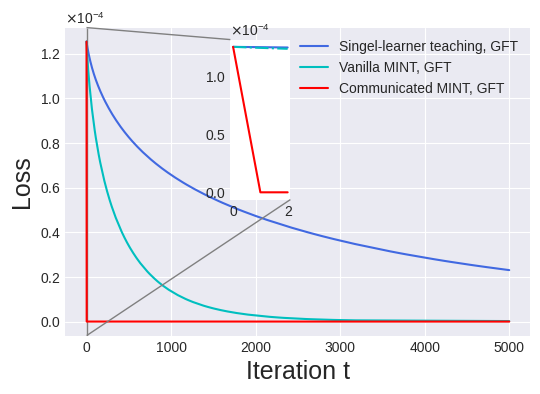

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.style.use('seaborn-v0_8-darkgrid')

sf = plt.figure(figsize=(6,4))
ax = sf.add_subplot()
plt.plot(Singleloss_t[0:len(Vanillaloss_t)],color='royalblue',label='Singel-learner teaching, GFT')
plt.plot(Vanillaloss_t,color='c',label='Vanilla MINT, GFT')
plt.plot(Advancedloss_t,color='red',label='Communicated MINT, GFT')
plt.ticklabel_format(style='sci', scilimits=(-5,-6), axis='y',useMathText=True )
plt.legend()
plt.xlabel('Iteration t', fontsize=18)
plt.ylabel('Loss', fontsize=18)

#-----------------zoom
xlim_1, xlim_2 = 0, 3
ax_zoom = sf.add_axes([0.4, 0.45, 0.1, 0.4], facecolor='white')
plt.plot(np.arange(xlim_1, xlim_2,1),Singleloss_t[xlim_1:xlim_2],color='royalblue')
plt.plot(np.arange(xlim_1, xlim_2,1),Vanillaloss_t[xlim_1:xlim_2],color='c',linestyle='-.')
plt.plot(np.arange(xlim_1, xlim_2,1),Advancedloss_t[xlim_1:xlim_2],color='red')

mark_inset(ax, ax_zoom, loc1=4, loc2=2, fc="none", ec="0.5")

plt.ticklabel_format(style='sci', scilimits=(-5,-6), axis='y',useMathText=True )

plt.show()
sf.savefig(save_path+'/Loss.pdf',bbox_inches='tight')

## When $A_t$ is useful, one iteration

In [5]:
import torch
import time
eta = 0.01  # Learning rate.
num_iterations = 5000  # Iterations for gradient descent.
seed = 0  # Random seed.

# Seed for reproducibility.
np.random.seed(seed)

In [4]:
# Create toy dataset.
def f_0_1(x):
    y = x
    return y

In [5]:
# Create toy dataset.
def f_0_2(x):
    y = x**2
    return y

In [6]:
# Create toy dataset.
def f_s_1(x, a, b):
    y = a*x+b*x**2+(1-a-b)*torch.cos(x)
    return y

In [7]:
# Create toy dataset.
def f_s_2(x, a, b):
    y = a*x+b*x**2+(1-a-b)*torch.sin(x)
    return y

In [8]:
# Obtain data.
pixels = torch.arange(-1, 1, 0.01)

In [9]:
f_0 = torch.vstack([f_0_1(pixels),f_0_2(pixels)])

In [10]:
f_s_all = []

iter_count = 0
for i in torch.arange(0,1.01,0.01):
    f_s_all.append(torch.vstack([f_s_1(pixels, i/2, i/2),f_s_2(pixels, i/3, 2*i/3)]))
#     f_s_1_all.append(f_s_1(pixels, a, b))
#     f_s_2_all.append(f_s_2(pixels, a, b))
    iter_count += 1
# f_s_all = torch.vstack([f_0_1(pixels),f_0_2(pixels)])

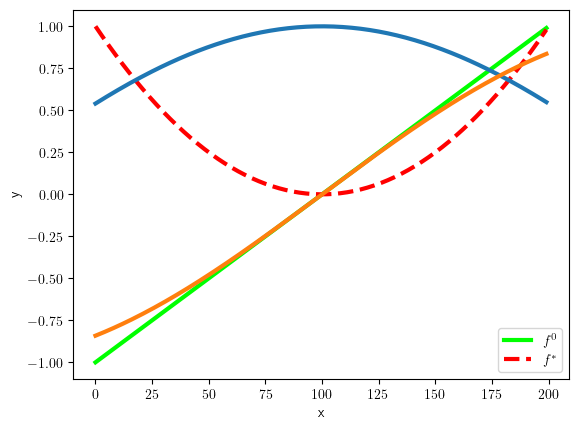

In [11]:
plt.plot(f_0_1(pixels),color='lime',label=r'$f^0$', linewidth=3)
plt.plot(f_0_2(pixels),color='red',label=r'$f^*$', linestyle='dashed', linewidth=3)
plt.plot(f_s_1(pixels, 0, 0), linewidth=3)
plt.plot(f_s_2(pixels, 0, 0), linewidth=3)
# plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.legend(loc='best', prop={'size': 10})
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [12]:
class AdvancedM(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvancedM, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        torch.nn.init.eye_(self.linear.weight)

    def forward(self, x):
        nor = self.linear.weight.sum(dim=1)
        outputs = self.linear(x)/nor
        return outputs

In [13]:
def A_t(f_t, f_star, N=5000, epsi=0.0001, eta = 0.0001):
    '''
    f_t_T_unnor = f_t.T
    f_s_T_unnor = f_star.T
    
    f_t_T = torch.nn.functional.normalize(f_t_T_unnor,p=2.0, dim=1)
    f_s_T = torch.nn.functional.normalize(f_s_T_unnor,p=2.0, dim=1)
    '''
    
    f_t_T = f_t.T
    f_s_T = f_star.T
    
    MatrixA = AdvancedM(len(f_t), len(f_star)).cuda()
    optimizer = torch.optim.SGD(MatrixA.parameters(), lr=eta)
    
    loss_t = []

    loss_t.append(torch.norm(MatrixA(f_t_T)-f_s_T))

    iter_count = 0
    while iter_count < N and loss_t[-1] > epsi:
        iter_count += 1
        
        roll = MatrixA

        loss = torch.norm(MatrixA(f_t_T)-f_s_T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if torch.norm(MatrixA(f_t_T)-f_s_T).item() > loss_t[-1]:
            MatrixA = roll #rolling
            break    
        
        loss_t.append(loss.item())
        #print(iter_count,'-th test loss:', loss_t[-1])
        
    A = MatrixA.state_dict()['linear.weight']
    A = A/(A.sum(dim=1))[:, None]
    
    return MatrixA, A


In [15]:
# torch.norm(f_0-f_s_all)
nocom = []
com = []
A_f_0 = []
for i in f_s_all:
    nocom.append(torch.norm(f_0-i))
    MatrixA_t, A = A_t(f_0.cuda(), i.cuda())
    a_f_0=MatrixA_t(f_0.T.cuda()).detach().T.cpu()
    A_f_0.append(a_f_0)
    com.append(torch.norm(a_f_0-i))

In [19]:
save_path = os.path.join(script_path,'out','toy')

In [20]:
torch.save([f_0, f_s_all, A_f_0, com],save_path+'/Atuseful.pt')

Load data

In [3]:
save_path = os.path.join(script_path,'out','toy')

In [6]:
f_0, f_s_all, A_f_0, com = torch.load(save_path+'/Atuseful.pt')

In [27]:
print('Final loss: ',com[-1],'\n','final communication matrix: ',A)

Final loss:  tensor(0.0009) 
 final communication matrix:  tensor([[0.5001, 0.4999],
        [0.3333, 0.6667]], device='cuda:0')


In [18]:
A

tensor([[0.5001, 0.4999],
        [0.3333, 0.6667]], device='cuda:0')

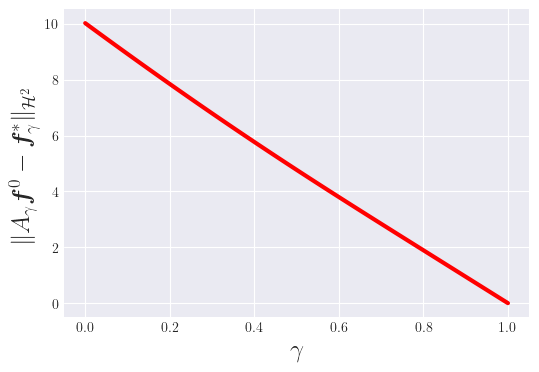

In [8]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')   #grey background, white line style

sf = plt.figure(figsize=(6,4))
plt.plot(torch.arange(0,1.01,0.01), com, color='red', linewidth=3)

plt.tick_params(axis='both', which='major', top='on', right='on', direction='in')
plt.xlabel(r'$\gamma$', fontsize=18)
plt.ylabel(r'$\|A_\gamma\bm{f}^0-\bm{f}^*_\gamma\|_{\mathcal{H}^2}$', fontsize=18)
plt.show()

sf.savefig(save_path+'/Atuseful.pdf',bbox_inches='tight')